### Code Cell 1
Import necessary libraries

In [4]:
# Sentiment Analysis Pipeline 
import pandas as pd
import matplotlib.pyplot as plt
from snownlp import SnowNLP
import jieba
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter
from tqdm import tqdm
import matplotlib

### Code Cell 2
Refined Configuration Block

In [5]:
tqdm.pandas()
sns.set_theme(style="whitegrid")
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['axes.unicode_minus'] = False

### Code Cell 3
Load Data

In [6]:
import pandas as pd
import os

# 1. List your files
file_paths = [
    "1. 特朗普关税王八拳.csv",
    "2. 【爆笑每日秀】美国人吐槽特朗普加征关税.csv",
    "3. 特朗普实施对等关税.csv",
    "4. 【巫师】全球关税混战背后.csv",
    "5. 【厉害】海湖庄园协议.csv"
]

# 2. Define the encodings to try
encodings = ["utf-8", "gbk", "gb18030"]

# 3. Read, merge, and write
all_dfs = []
for path in file_paths:
    for enc in encodings:
        try:
            df = pd.read_csv(path, encoding=enc)
            print(f"✅ Loaded '{os.path.basename(path)}' with encoding={enc}")
            all_dfs.append(df)
            break
        except Exception:
            continue
    else:
        raise ValueError(f"Failed to read file {path}; check encoding or path.")

# 4. Concatenate into one DataFrame
comments_total = pd.concat(all_dfs, ignore_index=True)
print(f"🔗 Merged DataFrame shape: {comments_total.shape}")

# 5. Export to CSV
comments_total.to_csv("comments_total.csv", index=False, encoding="utf-8-sig")
print("💾 Written merged file to 'comments_total.csv'")


✅ Loaded '1. 特朗普关税王八拳.csv' with encoding=utf-8
✅ Loaded '2. 【爆笑每日秀】美国人吐槽特朗普加征关税.csv' with encoding=utf-8
✅ Loaded '3. 特朗普实施对等关税.csv' with encoding=utf-8
✅ Loaded '4. 【巫师】全球关税混战背后.csv' with encoding=utf-8
✅ Loaded '5. 【厉害】海湖庄园协议.csv' with encoding=utf-8
🔗 Merged DataFrame shape: (41623, 14)
💾 Written merged file to 'comments_total.csv'


### Code Cell 4
Clean Comments block

In [7]:
# Load merged comments
df = pd.read_csv('comments_total.csv', encoding='utf-8-sig', engine='python', on_bad_lines='skip')

# Clean Comments
comment_col = "评论内容" if "评论内容" in df.columns else df.columns[0]
df_clean = (
    df[[comment_col, "点赞数"]]
    .dropna(subset=[comment_col, "点赞数"])
    .rename(columns={comment_col: "comment", "点赞数": "likes"})
)
df_clean["comment"] = df_clean["comment"].astype(str).str.strip()
df_clean["comment_length"] = df_clean["comment"].str.len()

# df_clean now contains the cleaned comments

### Code Cell 5
Sentiment Score & Labeling block

In [ ]:
# Load merged comments 
#df = pd.read_csv('comments_total.csv', encoding='utf-8-sig', engine='python', on_bad_lines='skip')

# Clean Comments
#comment_col = "评论内容" if "评论内容" in df.columns else df.columns[0]
#df_clean = (
#    df[[comment_col, "点赞数"]]
#    .dropna(subset=[comment_col, "点赞数"])
#    .rename(columns={comment_col: "comment", "点赞数": "likes"})
#)
#df_clean["comment"] = df_clean["comment"].astype(str).str.strip()
#df_clean["comment_length"] = df_clean["comment"].str.len()

# df_clean now contains the cleaned comments" "from snownlp import SnowNLP
#from tqdm.auto import tqdm

# enable progress_apply
#tqdm.pandas()

#print("Calculating sentiment scores...")

# Step 3: Sentiment Score & Labeling on df_clean
#df_clean["sentiment_score"] = df_clean["comment"].progress_apply(
#    lambda x: SnowNLP(str(x)).sentiments
#)
#df_clean["sentiment_label"] = df_clean["sentiment_score"].apply(
 #   lambda s: "positive" if s >= 0.5 else "negative"
#)

# (Optional) Save the result
#df_clean.to_csv("comments_with_sentiment.csv", index=False, encoding="utf-8-sig")

Calculating sentiment scores...


100%|██████████| 41623/41623 [02:12<00:00, 314.04it/s]


In [8]:
# High-Accuracy Chinese Sentiment Analysis using BERT (Hugging Face)
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from tqdm.auto import tqdm

# ========== Step 1: Load comment data ==========
df = pd.read_csv("comments_total.csv", encoding="utf-8-sig", engine="python", on_bad_lines="skip")

# Clean the comment data
comment_col = "评论内容" if "评论内容" in df.columns else df.columns[0]
df_clean = (
    df[[comment_col, "点赞数"]]
    .dropna(subset=[comment_col, "点赞数"])
    .rename(columns={comment_col: "comment", "点赞数": "likes"})
)
df_clean["comment"] = df_clean["comment"].astype(str).str.strip()
df_clean["comment_length"] = df_clean["comment"].str.len()

# ========== Step 2: Load pre-trained BERT sentiment model ==========
model_name = "uer/roberta-base-finetuned-jd-binary-chinese"
print("Loading BERT model and tokenizer...")
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)
model.eval()

# ========== Step 3: Define the sentiment prediction function ==========
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    label = "positive" if probs[0][1] > probs[0][0] else "negative"
    score = round(probs[0][1].item(), 4)
    return label, score

# ========== Step 4: Apply sentiment analysis in batch ==========
print("Analyzing comment sentiment...")
tqdm.pandas()
df_clean[["sentiment_label", "sentiment_score"]] = df_clean["comment"].progress_apply(
    lambda x: pd.Series(predict_sentiment(x))
)

# ========== Step 5: Save results ==========
df_clean.to_csv("comments_with_sentiment.csv", index=False, encoding="utf-8-sig")
print("✅ Sentiment analysis complete. Results saved to: comments_with_sentiment.csv")


d:\OneDrive - University of Illinois - Urbana\Documents\Python3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BERT model and tokenizer...
Analyzing comment sentiment...


100%|██████████| 41623/41623 [30:02<00:00, 23.10it/s]  

✅ Sentiment analysis complete. Results saved to: comments_with_sentiment.csv


### Code Cell 6
Sentiment Classification Function

In [9]:
# Step 4: Classify Sentiment Category

# Define sentiment category based on score thresholds:
# > 0.65 → Positive, < 0.35 → Negative, otherwise Neutral
def classify(score):
    if score > 0.65:
        return "Positive"
    elif score < 0.35:
        return "Negative"
    else:
        return "Neutral"

### Code Cell 7
Apply Sentiment Classification

In [10]:
# Step 5: Apply Sentiment Classification

# Create a new column with sentiment labels based on the sentiment score
df_clean["sentiment_label"] = df_clean["sentiment_score"].apply(classify)

### Code Cell 8
Visualization – Countplot of Sentiment Categories

C:\Users\18652\AppData\Local\Temp\ipykernel_28032\3381582377.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels_order, y=counts, palette="pastel")


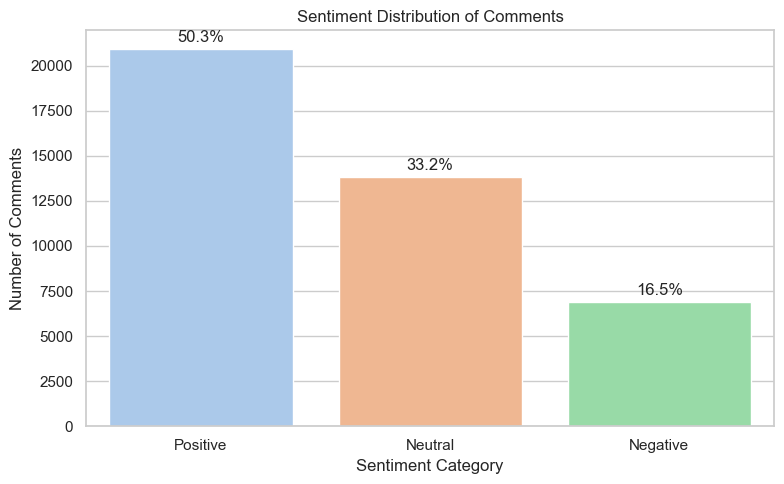

In [15]:
# Step 6: Count & percentage calculation
sentiment_counts = df_clean["sentiment_label"].value_counts(normalize=False)
sentiment_percent = df_clean["sentiment_label"].value_counts(normalize=True) * 100

# Ensure consistent order
labels_order = ["Positive", "Neutral", "Negative"]
counts = [sentiment_counts.get(label, 0) for label in labels_order]
percents = [sentiment_percent.get(label, 0) for label in labels_order]

# Step 7: Plot with percentages
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=labels_order, y=counts, palette="pastel")

# Add percentage text on each bar
for i, (count, percent) in enumerate(zip(counts, percents)):
    ax.text(i, count + max(counts) * 0.01, f"{percent:.1f}%", ha='center', va='bottom', fontsize=12)

plt.title("Sentiment Distribution of Comments")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Comments")
plt.tight_layout()
plt.show()


### Code Cell 9
Visualization – Comment Length vs Sentiment Score

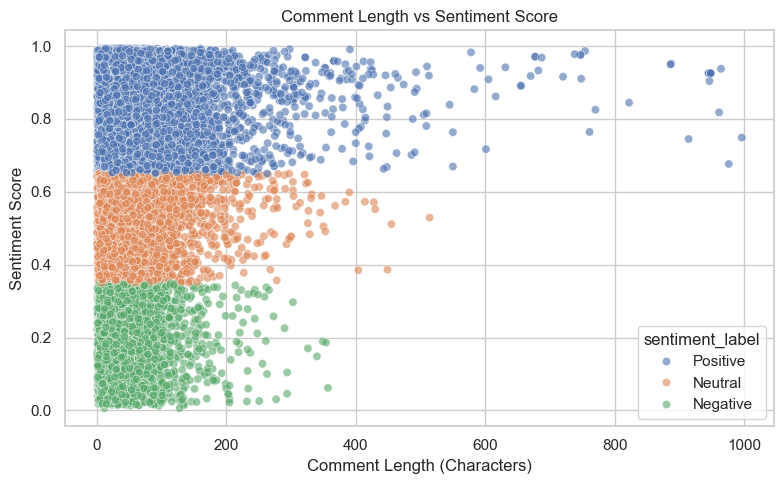

In [14]:
# Step 7: Visualization – Comment Length vs Sentiment Score

# Scatter plot showing the relationship between comment length and sentiment score
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df_clean,
    x="comment_length",
    y="sentiment_score",
    hue="sentiment_label",
    alpha=0.6
)
plt.title("Comment Length vs Sentiment Score")
plt.xlabel("Comment Length (Characters)")
plt.ylabel("Sentiment Score")
plt.tight_layout()
plt.show()


### Code Cell 10
Visualization – Boxplot of Sentiment Scores by Category

C:\Users\18652\AppData\Local\Temp\ipykernel_28032\2235981366.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


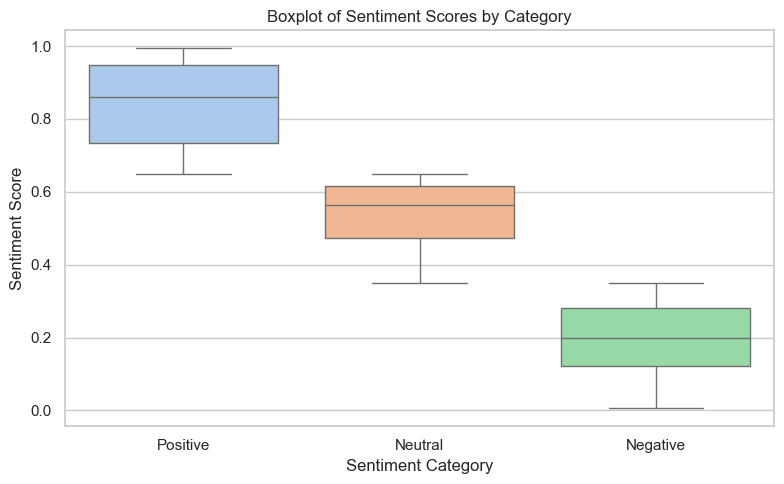

In [16]:
# Step 8: Visualization – Boxplot of Sentiment Scores

# Boxplot showing the distribution of sentiment scores within each sentiment category
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df_clean,
    x="sentiment_label",
    y="sentiment_score",
    palette="pastel",
    order=["Positive", "Neutral", "Negative"]
)
plt.title("Boxplot of Sentiment Scores by Category")
plt.xlabel("Sentiment Category")
plt.ylabel("Sentiment Score")
plt.tight_layout()
plt.show()


### Code Cell 11
Word Cloud – Define Stopwords

In [27]:
# Step 9: Word Cloud by Sentiment – Define Stopwords

# Define a set of common Chinese stopwords and topic-specific terms to exclude
stopwords = set([
    "的", "了", "在", "是", "我", "有", "和", "就", "不", "人", "都", "也", "说", "要", 
    "这", "up", "主", "你", "你们", "我们", "他们", "回复", "视频","觉得","已经", "因为", "可以", "所以", "什么","视频","如果", "但是","还是", "就是","知道","可能", "不是",
    "其实","那么","这么","一个","以前","现在","反正","应该","感觉","最后","时候","不会","自己","一定","或者","其他","只是","为什么","一定","怎么","这个","开始","而且","真的","这样","的话",
    "只能","直接","有点","没有","肯定","还有","不要","一些","很多","只有","这种","不能","准备","哪里","提供","以后","王骁","骁哥","主要","才能","过去","别人", "中国","美国","关税","之前",
    "目前","影响","一样","一下","小王","特朗普","川普","这些","一直","那些","那个","确实","为了","虽然","比如","大家","然后","一点","国家","东西","国内", "本来","两个","一半","所以","doge",
    "问题","需要","要么","得到","所有","除了","几天","真是","咱们","call","90"
])


### Code Cell 12
Word Cloud – Clean Word Extraction Function

In [28]:
# Step 10: Word Cloud – Clean Word Extraction Function

def get_clean_words(series):
    """
    Join all comments into a single string, perform Jieba word segmentation,
    and return a list of words that:
    - Are not in the stopwords list
    - Are longer than one character
    """
    text = " ".join(series.astype(str))  # Merge all comments into one string
    return [w for w in jieba.cut(text) if w not in stopwords and len(w) > 1]


### Code Cell 13
Prepare Word Lists for Word Cloud by Sentiment

In [29]:
# Step 11: Prepare Word Lists for Word Cloud by Sentiment

# Extract cleaned words from all comments
all_words = get_clean_words(df_clean["comment"])

# Extract cleaned words from only positive comments
positive_words = get_clean_words(df_clean[df_clean["sentiment_label"] == "Positive"]["comment"])

# Extract cleaned words from only negative comments
negative_words = get_clean_words(df_clean[df_clean["sentiment_label"] == "Negative"]["comment"])


### Code Cell 14
Define Word Cloud Plotting Function

In [31]:
# Step 12: Define Word Cloud Plotting Function

def plot_wordcloud(words, title, idx):
    """
    Generate and display a word cloud on the specified subplot.

    Parameters:
    - words: list of strings (pre-cleaned word tokens)
    - title: title of the subplot
    - idx: position in the 1x3 subplot grid (1, 2, or 3)
    """
    wc = WordCloud(
        font_path="simhei.ttf",       # Ensure Chinese font is available
        width=600,
        height=300,
        background_color="white"
    )
    plt.subplot(1, 3, idx)
    plt.imshow(wc.generate(" ".join(words)), interpolation="bilinear")
    plt.axis("off")
    plt.title(title)


### Code Cell 15
Plot Word Clouds – All / Positive / Negative

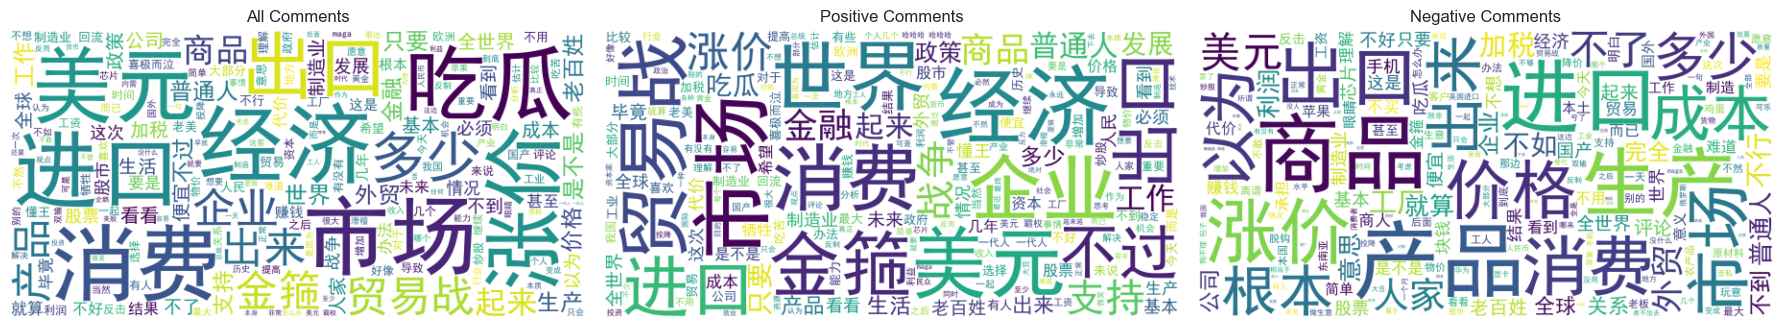

In [32]:
# Step 13: Plot Word Clouds – All / Positive / Negative

# Create a figure with 3 side-by-side word clouds
plt.figure(figsize=(18, 6))

# Plot word cloud for all comments
plot_wordcloud(all_words, "All Comments", 1)

# Plot word cloud for positive comments
plot_wordcloud(positive_words, "Positive Comments", 2)

# Plot word cloud for negative comments
plot_wordcloud(negative_words, "Negative Comments", 3)

# Adjust layout and display
plt.tight_layout()
plt.show()


### Code Cell 16
Word Cloud from Top 100 Liked Comments

In [34]:
# Step 14: Word Cloud from Top 100 Liked Comments

# Select the top 100 comments with the highest number of likes
top100 = df_clean.nlargest(100, "likes")["comment"]

# Extract and clean words from these high-engagement comments
top_words = get_clean_words(top100)


### Code Cell 17
Generate Word Cloud for Top 100 Liked Comments

In [35]:
# Step 15: Generate Word Cloud for Top 100 Liked Comments

# Create a WordCloud object and generate the word cloud using top 100 liked comments
wordcloud = WordCloud(
    font_path="simhei.ttf",     # Make sure the font path supports Chinese characters
    width=800,
    height=400,
    background_color="white"
).generate(" ".join(top_words))


### Code Cell 18
Display Word Cloud for Top 100 Liked Comments

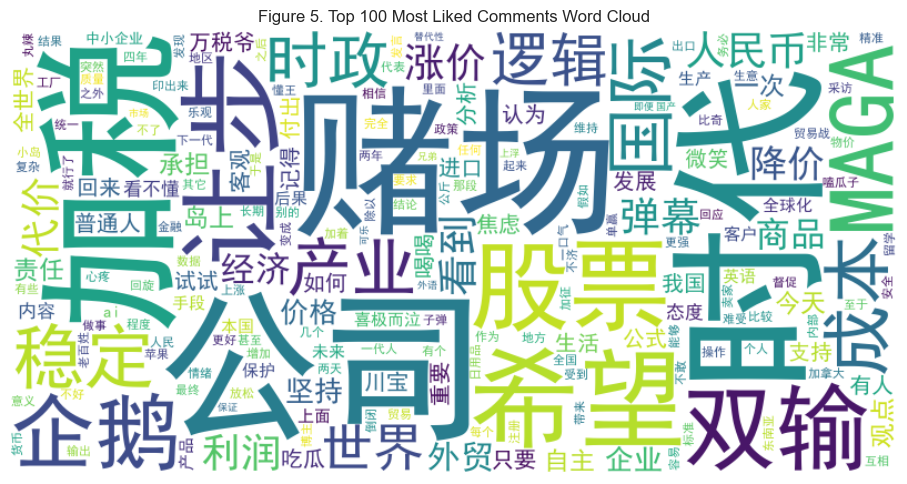

[('赌场', 7),
 ('时代', 7),
 ('公司', 7),
 ('加税', 6),
 ('希望', 6),
 ('让步', 6),
 ('股票', 5),
 ('双输', 5),
 ('企鹅', 5),
 ('稳定', 5)]

In [36]:
# Step 16: Display Word Cloud for Top 100 Liked Comments

# Plot the generated word cloud for visualizing high-engagement language
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axis lines
plt.title("Figure 5. Top 100 Most Liked Comments Word Cloud")
plt.tight_layout()
plt.show()

# Print top 10 keywords
top_10_keywords = Counter(top_words).most_common(10)
top_10_keywords

### Code Cell 19
Extract Top 10 Most Liked Comments

In [31]:
# Step 17: Extract Top 10 Most Liked Comments from df_clean

# Ensure df_clean exists and has the right columns
assert "likes" in df_clean.columns and "comment" in df_clean.columns, \
    "df_clean must contain 'likes' and 'comment' columns"

# Sort by likes descending and take the top 10
top_liked_comments = (
    df_clean
    .sort_values(by="likes", ascending=False)
    .loc[:, ["comment", "likes"]]
    .head(10)
    .reset_index(drop=True)
)

# Display the results
print("🔥 Top 10 Most Liked Comments:")
for idx, row in top_liked_comments.iterrows():
    print(f"\n{idx+1}. 👍 Likes: {row['likes']}")
    print(row["comment"])


🔥 Top 10 Most Liked Comments:

1. 👍 Likes: 36335
今天自己洗车省了40块钱，下午打开股票账户一看车没了[疑惑]

2. 👍 Likes: 19449
大致同意视频的观点，给🇺🇸加税是双输，但是认怂，会输得更惨。

3. 👍 Likes: 15922
很多MAGA是真的不知道关税最终是由自己承担的[笑哭]

4. 👍 Likes: 14380
丸辣哈哈我大学四年丸辣！

5. 👍 Likes: 13459
特朗普赌场都能经营倒闭 到这真绷不住了[大笑]

6. 👍 Likes: 9987
在川普的关税中有个叫做赫德岛和麦克唐纳群岛的国家，川普对他收取了10%的关税 但是该岛是个无人居住的小岛，岛上只有企鹅🐧

7. 👍 Likes: 9171
特朗普第一任时，督促中国科技自主，特朗普第二任时，督促欧亚大陆自主，每一次特朗普的高压都会给我们带来麻烦，但每一次也间接催促了中国产业进步，他真的我哭死[大哭]

8. 👍 Likes: 9080
活在这个时代，就得承担这个时代的责任，只是如果这一代必须牺牲，那么希望下一代能够好过一些。

9. 👍 Likes: 8843
顶级回旋镖

10. 👍 Likes: 8373
万税爷


### Code Cell 20
Extract Sample Comments by Sentiment Category

In [33]:
# Step 18: Extract Sample Comments by Sentiment Category (Top 10)

from snownlp import SnowNLP
import pandas as pd

# Load and clean the dataset
df = pd.read_csv("comments_total.csv", encoding="utf-8")
df = df[["评论内容"]].dropna().rename(columns={"评论内容": "评论"})
df["评论"] = df["评论"].astype(str).str.strip()

# Compute sentiment scores using SnowNLP
df["情感得分"] = df["评论"].apply(lambda x: SnowNLP(x).sentiments)

# Classify comments into sentiment categories
def classify(score):
    if score > 0.65:
        return "正面"
    elif score < 0.35:
        return "负面"
    else:
        return "中性"

df["情感分类"] = df["情感得分"].apply(classify)

# Map sentiment labels to English
label_map = {"正面": "Positive", "中性": "Neutral", "负面": "Negative"}
df["Sentiment_EN"] = df["情感分类"].map(label_map)

# Extract top 10 example comments for each sentiment category
examples = {
    "Positive": df[df["Sentiment_EN"] == "Positive"]["评论"].head(10).tolist(),
    "Neutral":  df[df["Sentiment_EN"] == "Neutral"]["评论"].head(10).tolist(),
    "Negative": df[df["Sentiment_EN"] == "Negative"]["评论"].head(10).tolist(),
}

# Print the sample results
for sentiment, samples in examples.items():
    print(f"\n{sentiment} examples:")
    for i, comment in enumerate(samples, 1):
        print(f"{i}. {comment}")



Positive examples:
1. 作为世界货币，不能把钱拿来打仗，要是专研科技，想办法攀科技树，把科技永远领先，如果美国现在能直接全国移民火星，他超发多少钱都不是问题[doge_金箍][滑稽]
2. 想知道这个算法的实际意义
3. 企鹅🐧拿啥来支付美国的债务
4. 是不是可以这么理解，一方面美国一直以来狂印低成本但高价值的美元收割世界，另一方面美国又不得不偿还债务来维持美元的信用，但是美国的美元结算体系导又致出口的低端商品相比其他国家毫无竞争力。（若有错误欢迎指正）[思考]
5. 选举制度在弱势时候体面的人拿不到票。[微笑]
6. 就这个视频的
7. 2018年贸易战，激发科技投资、半导体投资、国产替代热潮；2025关税战，我觉得也会激发内需、服务升级、出口外贸热潮。[OK]
8. 听说英国看病不要钱，真的吗？
9. 印度看病也不要钱。说白了要钱不要钱不是最主要的，医疗资源是否充足到可以普惠到每个平民才是最重要的
10. 【英国爸爸在中国看病，效率爆表，吓到腿都差点好了！】 https://www.bilibili.com/video/BV1y21vYtEAa/?share_source=copy_web&amp;vd_source=e6438866a084b458f341b0ea82d176bd

Neutral examples:
1. 刚刚
2. @HY_jkk
3. @AI视频总结
4. 如何？
5. 美國如果繼續使用高稅收低福利的模式，從人民手中搜刮錢財補貼產業，導致整體消費不足，通貨緊縮，最後一定會自食其果。
6. 医保不可能三角，最多只能选两个，免费、快捷、质量。你可以想想里面的道理。
7. 都是有套路的啦旁友
8. 这期说的太好了
9. 我们关税该怎么样怎么样，不能降到零，万一特朗普目的就是让我们把关税降到零呢，不就着道了
10. 支持

Negative examples:
1. 有没有资料分析大手子帮忙解答一下，贸易逆差除以总额的比例，也就是67％，假如美国没有除以2，直接加67％的关税，会发生什么
2. 超过50%就没有意义了。 实物没有哪笔交易有超50%利润。
3. 那以后国外的商品比如耐克鞋之类的会不会很贵？
4. 能不能把我的评论都回复下，我想看看我给你写了什么评论[脱单doge]
5. 诶，今天还没更新吗，那我先吃饭了[FG

In [35]:
# Step 18: Extract Sample Comments by Sentiment Category (Top 10) using df_clean

# Assuming df_clean already exists and contains 'comment' and 'sentiment_score'

import pandas as pd

# 1. Classify comments into three sentiment categories
def classify(score):
    if score > 0.65:
        return "Positive"
    elif score < 0.35:
        return "Negative"
    else:
        return "Neutral"

df_clean["sentiment_cat"] = df_clean["sentiment_score"].apply(classify)

# 2. For each category, take the top 10 by sentiment_score
examples = {}
for cat in ["Positive", "Neutral", "Negative"]:
    examples[cat] = (
        df_clean[df_clean["sentiment_cat"] == cat]
        .sort_values(by="sentiment_score", ascending=(cat=="Negative"))
        .head(10)["comment"]
        .tolist()
    )

# 3. Print the sample comments
for sentiment, samples in examples.items():
    print(f"\n{sentiment} examples:")
    for i, comment in enumerate(samples, 1):
        print(f"{i}. {comment}")



Positive examples:
1. 看看翟东升老师的也讲得很好，回看老师的以前的视频，全是预言家的观点。。。
2. 这期视频真的太棒了,醍醐灌顶啊
3. 听了之后学到了很多，不管是逻辑还是观点都非常清晰，受益匪浅。
4. 导致今日世界各国苦来兮苦的原因？  A.疯川想资导致的  B.长期税事导致的  C.高耸登导致的  D.（美债）追命利息导致的  E.弱业贸导致的  F.药乐萘导致的  G.欠兆碍盈导致的  H.扒翻海令导致的 I.商交处华导致的  J.扣利及没目导致的  K.（美国商品不能）一次卖够导致的  L.募集（黄金）卡导致的
5. 对比了好几个不同领域的博主，晓哥说的确实好
6. 王骁看起来情绪永远都是那么稳定，台风永远是那么正，说的东西永远都是那么深入浅出。点个赞！
7. 这一期讲得真清晰，好评
8. 小王这期真的得点赞，视角、格局都有，分析得条例清晰，有理有据
9. 经典老图啊
10. 看完王骁，对这次贸易战有了更清晰的认知

Neutral examples:
1. 回复 @夜耶耶Yeah :谢谢
2. [吃瓜][吃瓜]华尔街可是美国最赚钱的地方啊
3. 痛苦是难免的，但是我们是必胜的，比起吃苦抗压欧美根本不够看
4. 回复 @鸣潮宇宙第一 :18年就开始打贸易战了，之前的怎么可能是口嗨？
5. 华尔街金融大鳄损失关我底特律下岗工人什么事
6. 回复 @于毅98 :其实高通原产地不是美国
7. 回复 @忘川的涟漪丶 :没还过吧感觉
8. 回复 @黑弥撒丿 :好有逻辑呢[星星眼]是数据大师！我们有救啦！
9. 美国gdp占全球四分之一，股市却占了全球股市近七成[doge]。
10. 回复 @龙邻 :别跟网上这群人理性讨论，国家给的政策是一点都看不到。只会搁这输出情绪，跟美国的红脖子是一样的智商。他们就想自己躺着然后给他们发钱就可以，但发钱就是美国现在的状况，通胀上天低层生活越来越艰难，中产财富缩水往底层滑落，财富越来越往上层聚集。这群人有这脑子思考这么多？

Negative examples:
1. 没有 这还得熬多久 差评
2. 回复 @_Handsome_666778 :还顶着个美国的IP，丢人的玩意。先去学学做人，再没有了解事情之前别瞎咧咧。对于你这种什么不看张口就来的傻*，给你解释一句都是浪费时间。还是那句话，你但凡看过点儿，也不

### Code Cell 21
Plot Histogram of Sentiment Scores

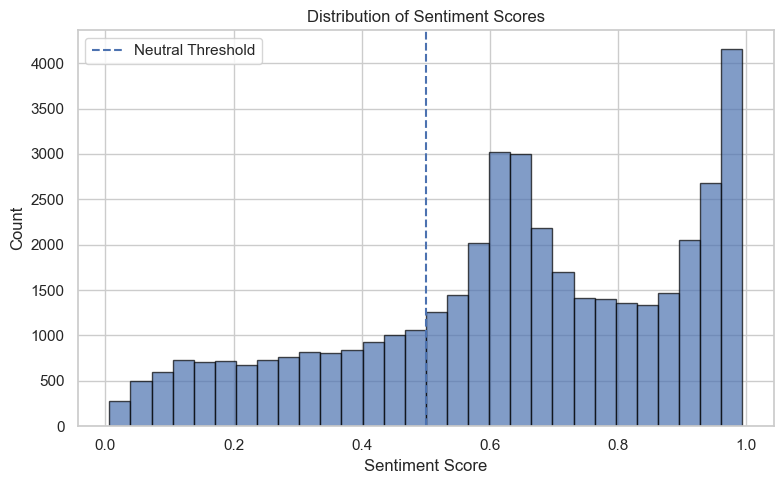

In [36]:
import matplotlib.pyplot as plt

# Step 19: Plot Histogram of Sentiment Scores using df_clean

plt.figure(figsize=(8, 5))
plt.hist(df_clean["sentiment_score"], bins=30, edgecolor='black', alpha=0.7)
plt.axvline(0.5, linestyle='--', linewidth=1.5, label='Neutral Threshold')
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


### Code Cell 22
Extract Sample Comments by Sentiment Score Range

In [37]:
# Step 20: Extract Sample Comments by Sentiment Score Range using df_clean

# Define sentiment score intervals
score_ranges = {
    "Very Negative (0.00–0.20)": (0.00, 0.20),
    "Moderately Negative (0.20–0.45)": (0.20, 0.45),
    "Neutral (0.45–0.65)": (0.45, 0.65),
    "Moderately Positive (0.65–0.80)": (0.65, 0.80),
    "Very Positive (0.80–1.00)": (0.80, 1.00)
}

# Extract and print 3 example comments from each sentiment range
for label, (low, high) in score_ranges.items():
    subset = df_clean[
        (df_clean["sentiment_score"] > low) &
        (df_clean["sentiment_score"] <= high)
    ]
    examples = subset["comment"].head(3).tolist()
    print(f"\n🔹 {label} examples:")
    for i, comment in enumerate(examples, 1):
        print(f"{i}. {comment}")



🔹 Very Negative (0.00–0.20) examples:
1. 超过50%就没有意义了。 实物没有哪笔交易有超50%利润。
2. 半个月了还在歇吗？
3. 请大家去看看小红书上的跟国家相关 跟韩偷国相关的帖子 现在的小红书已经成为反华平台了 外国下水军了！ 全部都是造谣辱骂侮辱中国的评论 我们在中国的平台让人给欺负了！！跟推特差不多了！跟几年前完全不一样了 请大家引起重视！大家去小红书支援下！还有让上头看到严重性！！扩！

🔹 Moderately Negative (0.20–0.45) examples:
1. 有没有资料分析大手子帮忙解答一下，贸易逆差除以总额的比例，也就是67％，假如美国没有除以2，直接加67％的关税，会发生什么
2. 能不能把我的评论都回复下，我想看看我给你写了什么评论[脱单doge]
3. 就这个视频的

🔹 Neutral (0.45–0.65) examples:
1. 那以后国外的商品比如耐克鞋之类的会不会很贵？
2. @HY_jkk
3. 生病了排队一个月免费医疗，或者掏钱付费治疗，你选哪个

🔹 Moderately Positive (0.65–0.80) examples:
1. 企鹅🐧拿啥来支付美国的债务
2. 选举制度在弱势时候体面的人拿不到票。[微笑]
3. 诶，今天还没更新吗，那我先吃饭了[FGO_耶]

🔹 Very Positive (0.80–1.00) examples:
1. 作为世界货币，不能把钱拿来打仗，要是专研科技，想办法攀科技树，把科技永远领先，如果美国现在能直接全国移民火星，他超发多少钱都不是问题[doge_金箍][滑稽]
2. 想知道这个算法的实际意义
3. 是不是可以这么理解，一方面美国一直以来狂印低成本但高价值的美元收割世界，另一方面美国又不得不偿还债务来维持美元的信用，但是美国的美元结算体系导又致出口的低端商品相比其他国家毫无竞争力。（若有错误欢迎指正）[思考]


### Code Cell 23
Sentiment Visualization Overview

C:\Users\18652\AppData\Local\Temp\ipykernel_3640\2557242583.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


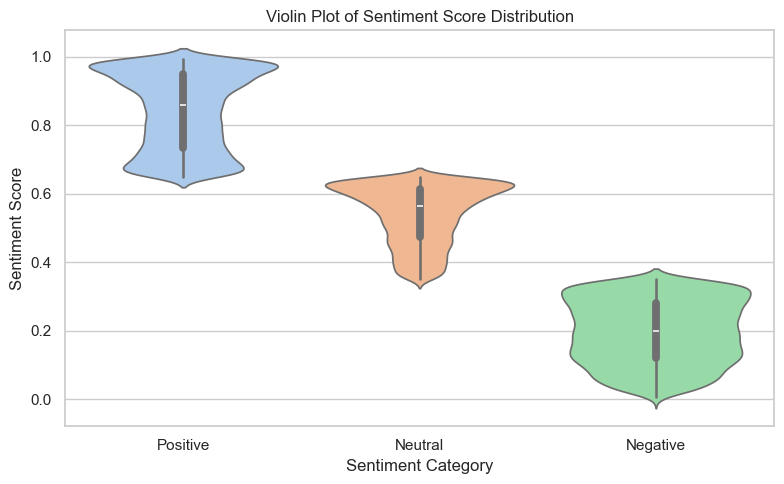

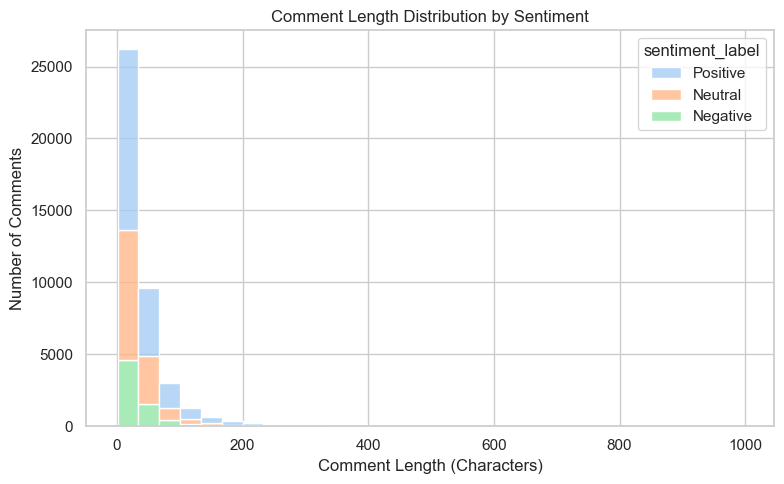

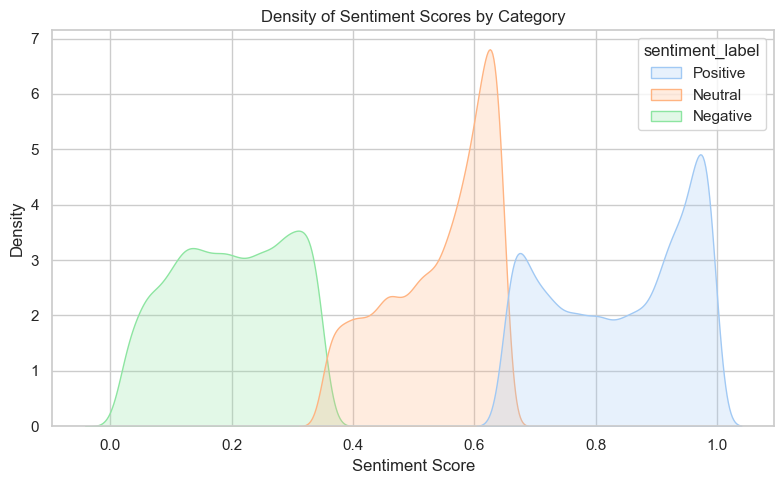

In [38]:
# Step 21: Visualize Sentiment Patterns – Score, Length, Distribution

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from snownlp import SnowNLP

# Classify into sentiment labels
def classify(score):
    if score > 0.65:
        return "Positive"
    elif score < 0.35:
        return "Negative"
    else:
        return "Neutral"

df_clean["sentiment_label"] = df_clean["sentiment_score"].apply(classify)

# Seaborn style setup
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False

# Prepare plotting DataFrame
df_viz = df_clean[["comment", "comment_length", "sentiment_score", "sentiment_label"]].copy()

# === Plot 1: Violin Plot of Sentiment Scores by Category ===
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df_viz,
    x="sentiment_label",
    y="sentiment_score",
    palette="pastel",
    order=["Positive", "Neutral", "Negative"]
)
plt.title("Violin Plot of Sentiment Score Distribution")
plt.xlabel("Sentiment Category")
plt.ylabel("Sentiment Score")
plt.tight_layout()
plt.show()

# === Plot 2: Histogram of Comment Lengths by Sentiment ===
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df_viz,
    x="comment_length",
    hue="sentiment_label",
    multiple="stack",
    bins=30,
    palette="pastel"
)
plt.title("Comment Length Distribution by Sentiment")
plt.xlabel("Comment Length (Characters)")
plt.ylabel("Number of Comments")
plt.tight_layout()
plt.show()

# === Plot 3: KDE Plot of Sentiment Score Density ===
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=df_viz,
    x="sentiment_score",
    hue="sentiment_label",
    common_norm=False,
    fill=True,
    palette="pastel"
)
plt.title("Density of Sentiment Scores by Category")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


### Code Cell 24
Engagement Analysis – Likes & Replies vs Sentiment Score

In [43]:
import pandas as pd

# Load merged comments
df = pd.read_csv('comments_total.csv', encoding='utf-8-sig', engine='python', on_bad_lines='skip')

# Identify key columns
comment_col = "评论内容" if "评论内容" in df.columns else df.columns[0]
likes_col = "点赞数" if "点赞数" in df.columns else "likes"
replies_col = "回复数" if "回复数" in df.columns else "replies"

# Select and rename relevant columns
columns_to_use = [col for col in [comment_col, likes_col, replies_col] if col in df.columns]
df_clean = df[columns_to_use].copy()

rename_map = {comment_col: "comment"}
if likes_col in df_clean.columns:
    rename_map[likes_col] = "likes"
if replies_col in df_clean.columns:
    rename_map[replies_col] = "replies"

df_clean = df_clean.rename(columns=rename_map)

# Drop missing or invalid entries
df_clean = df_clean.dropna(subset=["comment"])
df_clean["comment"] = df_clean["comment"].astype(str).str.strip()
df_clean["comment_length"] = df_clean["comment"].str.len()

# Convert numeric columns
if "likes" in df_clean.columns:
    df_clean["likes"] = pd.to_numeric(df_clean["likes"], errors="coerce")
if "replies" in df_clean.columns:
    df_clean["replies"] = pd.to_numeric(df_clean["replies"], errors="coerce")

# Final clean DataFrame is ready
print("✅ Cleaned DataFrame ready with shape:", df_clean.shape)


✅ Cleaned DataFrame ready with shape: (41623, 4)


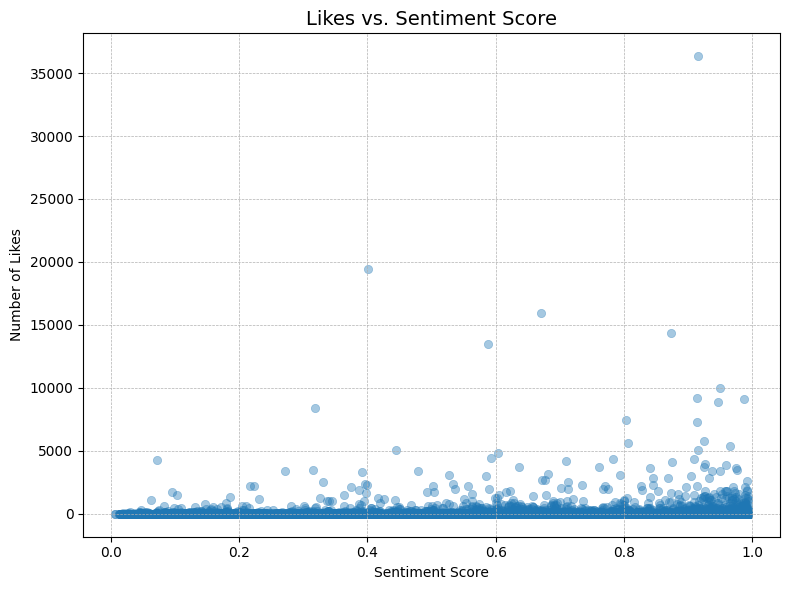

No meaningful 'replies' data to plot.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load processed data
df = pd.read_csv("comments_with_sentiment.csv", encoding="utf-8-sig")

# Clean and ensure valid types
df["sentiment_score"] = pd.to_numeric(df["sentiment_score"], errors="coerce")
df["likes"] = pd.to_numeric(df["likes"], errors="coerce")
df["replies"] = pd.to_numeric(df["回复数"], errors="coerce") if "回复数" in df.columns else 0
df["replies"] = df["replies"].fillna(0)

# Filter for plotting
df_plot = df.dropna(subset=["sentiment_score", "likes"]).copy()

# === Plot 1: Likes vs. Sentiment Score ===
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_plot, x="sentiment_score", y="likes", alpha=0.4, edgecolor=None)
plt.title("Likes vs. Sentiment Score", fontsize=14)
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Likes")
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# === Plot 2: Replies vs. Sentiment Score (if available) ===
if "replies" in df_plot.columns and df_plot["replies"].sum() > 0:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df_plot, x="sentiment_score", y="replies", alpha=0.4, color="orange", edgecolor=None)
    plt.title("Replies vs. Sentiment Score", fontsize=14)
    plt.xlabel("Sentiment Score")
    plt.ylabel("Number of Replies")
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()
else:
    print("No meaningful 'replies' data to plot.")


C:\Users\18652\AppData\Local\Temp\ipykernel_26820\1308507174.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_binned.groupby("sentiment_bin")[["likes", "replies"]].mean().reset_index()


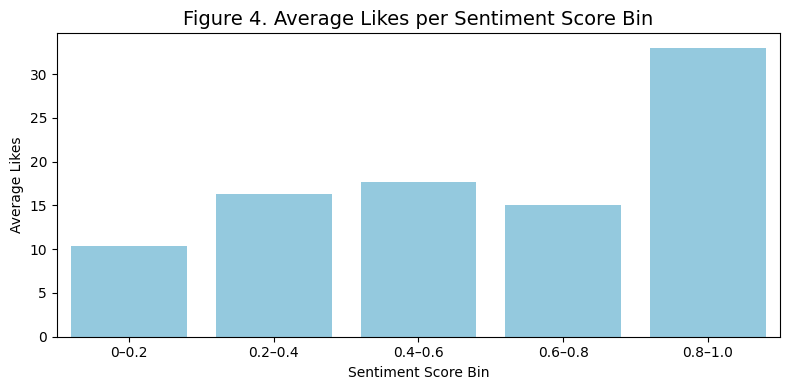

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🧹 Step 1: Ensure column names are standardized
df_plot = df_plot.rename(columns={"点赞数": "likes", "回复数": "replies"})

# Step 2: Define sentiment bins and labels
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['0–0.2', '0.2–0.4', '0.4–0.6', '0.6–0.8', '0.8–1.0']

# Bin sentiment scores
df_plot["sentiment_bin"] = pd.cut(df_plot["sentiment_score"], bins=bins, labels=labels, include_lowest=True)

# Drop rows with missing bin info
df_binned = df_plot.dropna(subset=["sentiment_bin", "likes", "replies"])

# Step 3: Group by sentiment bin and calculate mean engagement
summary = df_binned.groupby("sentiment_bin")[["likes", "replies"]].mean().reset_index()

# === 📊 Plot 1: Average Likes by Sentiment Bin ===
plt.figure(figsize=(8, 4))
sns.barplot(data=summary, x="sentiment_bin", y="likes", color="skyblue")
plt.title("Figure 4. Average Likes per Sentiment Score Bin", fontsize=14)
plt.xlabel("Sentiment Score Bin")
plt.ylabel("Average Likes")
plt.tight_layout()
plt.show()




### Code Cell 25
Comments related to South Korea

In [17]:

# Re-import necessary libraries after kernel reset
import pandas as pd

# Load the dataset again
df = pd.read_csv("comments_with_sentiment.csv", encoding="utf-8-sig")

# Filter comments containing the keyword "韩国"
korea_comments = df[df["comment"].astype(str).str.contains("韩国", na=False)]

# Count number of matching comments
num_korea_comments = korea_comments.shape[0]

# Calculate average sentiment score
avg_korea_sentiment = korea_comments["sentiment_score"].mean()

num_korea_comments, avg_korea_sentiment


(69, 0.6031333333333332)

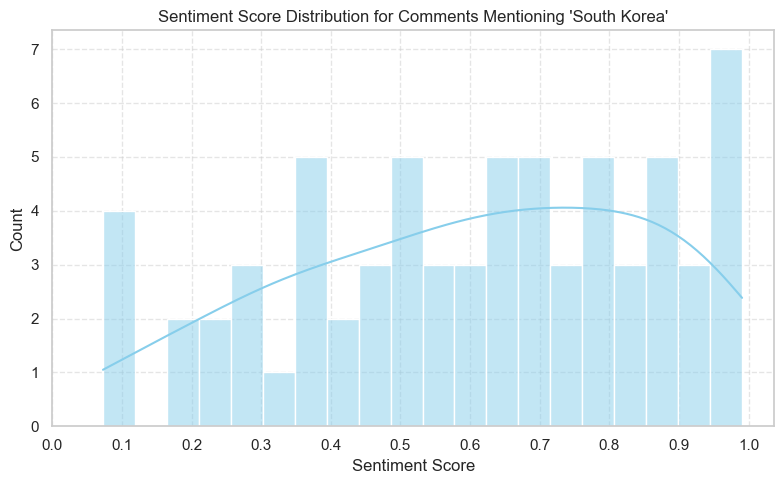

In [20]:
import numpy as np

# Re-plot with specified x-axis ticks from 0 to 1 in 0.1 increments
plt.figure(figsize=(8, 5))
sns.histplot(korea_comments["sentiment_score"], bins=20, kde=True, color="skyblue")
plt.title("Sentiment Score Distribution for Comments Mentioning 'South Korea'")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")
plt.xticks(np.arange(0, 1.01, 0.1))  # x-axis from 0 to 1 with 0.1 intervals
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
